In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
import scipy.io as sio
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [4]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

In [5]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
    wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

    features = np.concatenate([wav_mfcc_std_mean])
    return features

In [10]:
def build_batchnorm_cnn_no_do(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv1D(kernel_size=25, filters=8, strides=1, padding='valid', 
                  activation='relu', input_shape=input_shape))  
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid', 
                          activation='relu'))  
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
#         model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [13]:
# model = build_cnn(conv_num=3, fcn_num=1)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.2039 - acc: 0.3151
Epoch 00001: val_loss improved from inf to 1.67138, saving model to model/checkpoint/1D_CNN_1_conv_1_fcn_checkpoint/01-1.6714.hdf5
36805/36805 [==============================] - 20s 552us/sample - loss: 2.2038 - acc: 0.3152 - val_loss: 1.6714 - val_acc: 0.5031
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4969 - acc: 0.5310- ETA: 0s - loss: 1.5019 -
Epoch 00002: val_loss improved from 1.67138 to 1.35223, saving model to model/checkpoint/1D_CNN_1_conv_1_fcn_checkpoint/02-1.3522.hdf5
36805/36805 [==============================] - 20s 531us/sample - loss: 1.4969 - acc: 0.5310 - val_los

Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9868
Epoch 00025: val_loss did not improve from 0.93093
36805/36805 [==============================] - 19s 528us/sample - loss: 0.0625 - acc: 0.9868 - val_loss: 1.1332 - val_acc: 0.7291
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9861
Epoch 00026: val_loss did not improve from 0.93093
36805/36805 [==============================] - 19s 521us/sample - loss: 0.0624 - acc: 0.9861 - val_loss: 1.1165 - val_acc: 0.7349
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9873
Epoch 00027: val_loss did not improve from 0.93093
36805/36805 [==============================] - 19s 520us/sample - loss: 0.0632 - acc: 0.9873 - val_loss: 1.1598 - val_acc: 0.7293
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9878
Epoch 00028: val_loss did not improve from 0.93093
36805/36805 [=====

Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9946
Epoch 00055: val_loss did not improve from 0.93093
36805/36805 [==============================] - 19s 518us/sample - loss: 0.0254 - acc: 0.9946 - val_loss: 1.3315 - val_acc: 0.7389
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9952
Epoch 00056: val_loss did not improve from 0.93093
36805/36805 [==============================] - 19s 519us/sample - loss: 0.0246 - acc: 0.9952 - val_loss: 1.3273 - val_acc: 0.7403
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9944
Epoch 00057: val_loss did not improve from 0.93093
36805/36805 [==============================] - 19s 529us/sample - loss: 0.0252 - acc: 0.9944 - val_loss: 1.3620 - val_acc: 0.7403
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9936
Epoch 00058: val_loss did not improve from 0.93093
36805/36805 [=====

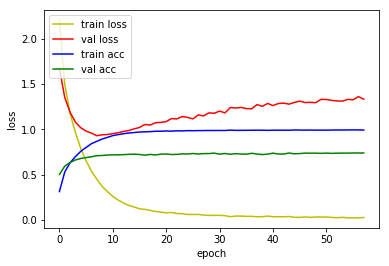

4815/4815 [==============================] - 1s 153us/sample - loss: 1.5559 - acc: 0.7016
Loss: 1.5559255565809684 Accuracy: 0.70155764
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.3877 - acc: 0.2325
Epoch 00001: val_loss improved from inf to 1.78279, saving model to model/checkpoint/1D_CNN_1_conv_2_fcn_checkpoint/01-1.7828.hdf5
36805/36805 [==============================] - 20s 547us/sample - loss: 2.3877 - acc: 0.2325 - val_loss: 1.7828 - val_acc: 0.4419
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7355 - acc: 0.4361
Epoch 00002: val_loss improved from 1.78279 to 1.41432, saving model to model/checkpoint/1D_CNN_1_conv_2_fcn_checkpoint/02-1.4143.hdf5
36805/36805 [==============================] - 20s 535us/sample - loss: 1.7355 - acc: 0.4361 - val_loss: 1.4143 - val_acc: 0.5581
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4276 - acc: 0.5357
E

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0885 - acc: 0.9754
Epoch 00027: val_loss did not improve from 0.81899
36805/36805 [==============================] - 19s 528us/sample - loss: 0.0885 - acc: 0.9754 - val_loss: 1.0575 - val_acc: 0.7636
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9764
Epoch 00028: val_loss did not improve from 0.81899
36805/36805 [==============================] - 20s 538us/sample - loss: 0.0822 - acc: 0.9764 - val_loss: 1.0295 - val_acc: 0.7629
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9765
Epoch 00029: val_loss did not improve from 0.81899
36805/36805 [==============================] - 20s 536us/sample - loss: 0.0837 - acc: 0.9765 - val_loss: 1.0679 - val_acc: 0.7675
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0798 - acc: 0.9770
Epoch 00030: val_loss did not improve from 0.81899
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9880
Epoch 00057: val_loss did not improve from 0.81899
36805/36805 [==============================] - 19s 527us/sample - loss: 0.0421 - acc: 0.9880 - val_loss: 1.2579 - val_acc: 0.7694
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9881
Epoch 00058: val_loss did not improve from 0.81899
36805/36805 [==============================] - 19s 529us/sample - loss: 0.0422 - acc: 0.9881 - val_loss: 1.2096 - val_acc: 0.7699
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9898
Epoch 00059: val_loss did not improve from 0.81899
36805/36805 [==============================] - 19s 528us/sample - loss: 0.0360 - acc: 0.9898 - val_loss: 1.2398 - val_acc: 0.7724
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9901
Epoch 00060: val_loss did not improve from 0.81899
36805/36805 [=====

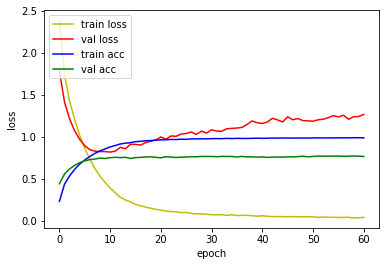

4815/4815 [==============================] - 1s 161us/sample - loss: 1.5104 - acc: 0.7261
Loss: 1.5103752758148923 Accuracy: 0.7260644
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.1376 - acc: 0.3084
Epoch 00001: val_loss improved from inf to 1.60269, saving model to model/checkpoint/1D_CNN_2_conv_1_fcn_checkpoint/01-1.6027.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 2.1375 - acc: 0.3085 - val_loss: 1.6027 - val_acc: 0.4915
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4957 - acc: 0.5168
Epoch 00002: val_loss improved from 1.60269 to 1.26562, saving model to model/checkpoint/1D_CNN_2_conv_1_fcn_checkpoint/02-1.2656.hdf5
36805/36805 [==============================] - 17s 470us/sample - loss: 1.4957 - acc: 0.5168 - val_loss: 1.2656 - val_acc: 0.6231
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2020 - acc: 0.6166
Ep

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9844
Epoch 00027: val_loss did not improve from 0.64773
36805/36805 [==============================] - 17s 466us/sample - loss: 0.0577 - acc: 0.9844 - val_loss: 0.7926 - val_acc: 0.8109
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0564 - acc: 0.9839
Epoch 00028: val_loss did not improve from 0.64773
36805/36805 [==============================] - 17s 473us/sample - loss: 0.0564 - acc: 0.9839 - val_loss: 0.8119 - val_acc: 0.8130
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9859
Epoch 00029: val_loss did not improve from 0.64773
36805/36805 [==============================] - 17s 475us/sample - loss: 0.0508 - acc: 0.9859 - val_loss: 0.8253 - val_acc: 0.8141
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9874
Epoch 00030: val_loss did not improve from 0.64773
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9943
Epoch 00057: val_loss did not improve from 0.64773
36805/36805 [==============================] - 17s 462us/sample - loss: 0.0205 - acc: 0.9943 - val_loss: 0.9819 - val_acc: 0.8183
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9951
Epoch 00058: val_loss did not improve from 0.64773
36805/36805 [==============================] - 17s 463us/sample - loss: 0.0184 - acc: 0.9951 - val_loss: 0.9716 - val_acc: 0.8183
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9948
Epoch 00059: val_loss did not improve from 0.64773
36805/36805 [==============================] - 17s 464us/sample - loss: 0.0185 - acc: 0.9948 - val_loss: 0.9716 - val_acc: 0.8190
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9952
Epoch 00060: val_loss did not improve from 0.64773
36805/36805 [=====

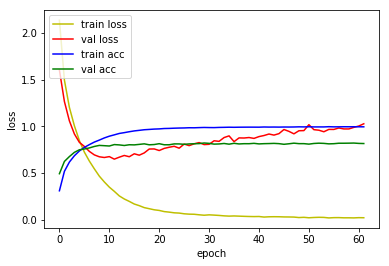

4815/4815 [==============================] - 1s 179us/sample - loss: 1.2360 - acc: 0.7767
Loss: 1.236001495012737 Accuracy: 0.77673936
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.1733 - acc: 0.2833
Epoch 00001: val_loss improved from inf to 1.57638, saving model to model/checkpoint/1D_CNN_2_conv_2_fcn_checkpoint/01-1.5764.hdf5
36805/36805 [==============================] - 18s 490us/sample - loss: 2.1732 - acc: 0.2834 - val_loss: 1.5764 - val_acc: 0.5120
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5536 - acc: 0.4878
Epoch 00002: val_loss improved from 1.57638 to 1.19816, saving model to model/checkpoint/1D_CNN_2_conv_2_fcn_checkpoint/02-1.1982.hdf5
36805/36805 [==============================] - 18s 485us/sample - loss: 1.5536 - acc: 0.4877 - val_loss: 1.1982 - val_acc: 0.6177
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2480 - acc: 0.5887
Ep

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0623 - acc: 0.9821
Epoch 00026: val_loss did not improve from 0.48713
36805/36805 [==============================] - 18s 480us/sample - loss: 0.0623 - acc: 0.9821 - val_loss: 0.6283 - val_acc: 0.8481
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9820
Epoch 00027: val_loss did not improve from 0.48713
36805/36805 [==============================] - 18s 482us/sample - loss: 0.0607 - acc: 0.9820 - val_loss: 0.6353 - val_acc: 0.8498
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9842
Epoch 00028: val_loss did not improve from 0.48713
36805/36805 [==============================] - 18s 483us/sample - loss: 0.0538 - acc: 0.9842 - val_loss: 0.6702 - val_acc: 0.8435
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0505 - acc: 0.9852
Epoch 00029: val_loss did not improve from 0.48713
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9950
Epoch 00056: val_loss did not improve from 0.48713
36805/36805 [==============================] - 17s 472us/sample - loss: 0.0180 - acc: 0.9950 - val_loss: 0.7451 - val_acc: 0.8542
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9946
Epoch 00057: val_loss did not improve from 0.48713
36805/36805 [==============================] - 17s 475us/sample - loss: 0.0184 - acc: 0.9946 - val_loss: 0.8080 - val_acc: 0.8446
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9943
Epoch 00058: val_loss did not improve from 0.48713
36805/36805 [==============================] - 18s 482us/sample - loss: 0.0195 - acc: 0.9943 - val_loss: 0.7526 - val_acc: 0.8512
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9938
Epoch 00059: val_loss did not improve from 0.48713
36805/36805 [=====

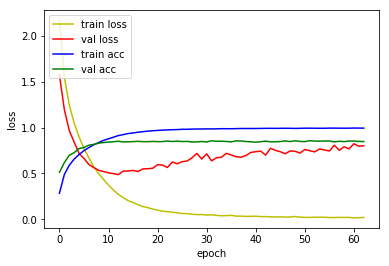

4815/4815 [==============================] - 1s 185us/sample - loss: 1.0415 - acc: 0.8183
Loss: 1.0415437503519582 Accuracy: 0.8182762
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.1049 - acc: 0.3233
Epoch 00001: val_loss improved from inf to 1.49711, saving model to model/checkpoint/1D_CNN_3_conv_1_fcn_checkpoint/01-1.4971.hdf5
36805/36805 [==============================] - 17s 453us/sample - loss: 2.1047 - acc: 0.3233 - val_loss: 1.4971 - val_acc: 0.5185
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.4092 - acc: 0.5504
Epoch 00002: val_loss improved from 1.49711 to 1.14152, saving model to model/checkpoint/1D_CNN_3_conv_1_fcn_checkpoint/02-1.1415.hdf5
36805/36805 [==============================] - 16s 436us/sample - loss: 1.4091 - acc: 0.5505 - val_loss: 1.1415 - val_acc: 0.6410
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1349 - acc: 0.6401
Ep

Epoch 24/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1506 - acc: 0.9522
Epoch 00024: val_loss did not improve from 0.32381
36805/36805 [==============================] - 16s 436us/sample - loss: 0.1507 - acc: 0.9522 - val_loss: 0.3314 - val_acc: 0.9022
Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1324 - acc: 0.9575
Epoch 00025: val_loss did not improve from 0.32381
36805/36805 [==============================] - 16s 436us/sample - loss: 0.1323 - acc: 0.9575 - val_loss: 0.3439 - val_acc: 0.8984
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1197 - acc: 0.9631
Epoch 00026: val_loss did not improve from 0.32381
36805/36805 [==============================] - 16s 436us/sample - loss: 0.1197 - acc: 0.9630 - val_loss: 0.3506 - val_acc: 0.9010
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1149 - acc: 0.9645
Epoch 00027: val_loss did not improve from 0.32381
36805/36805 [=====

Epoch 54/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9929
Epoch 00054: val_loss did not improve from 0.32381
36805/36805 [==============================] - 16s 436us/sample - loss: 0.0241 - acc: 0.9928 - val_loss: 0.4347 - val_acc: 0.9094
Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9923
Epoch 00055: val_loss did not improve from 0.32381
36805/36805 [==============================] - 16s 437us/sample - loss: 0.0264 - acc: 0.9923 - val_loss: 0.4662 - val_acc: 0.9052
Epoch 56/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.32381
36805/36805 [==============================] - 16s 436us/sample - loss: 0.0207 - acc: 0.9940 - val_loss: 0.4717 - val_acc: 0.8994
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9936
Epoch 00057: val_loss did not improve from 0.32381
36805/36805 [=====

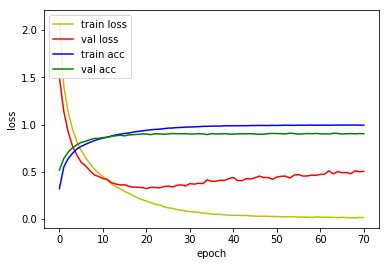

4815/4815 [==============================] - 1s 189us/sample - loss: 0.6372 - acc: 0.8777
Loss: 0.6372340842044737 Accuracy: 0.8776739
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.2078 - acc: 0.2722
Epoch 00001: val_loss improved from inf to 1.58740, saving model to model/checkpoint/1D_CNN_3_conv_2_fcn_checkpoint/01-1.5874.hdf5
36805/36805 [==============================] - 17s 468us/sample - loss: 2.2076 - acc: 0.2722 - val_loss: 1.5874 - val_acc: 0.4971
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5158 - acc: 0.5062
Epoch 00002: val_loss improved from 1.58740 to 1.10762, saving model to model/checkpoint/1D_CNN_3_conv_2_fcn_checkpoint/02-1.1076.hdf5
36805/36805 [==============================] - 16s 445us/sample - loss: 1.5158 - acc: 0.5062 - val_loss: 1.1076 - val_acc: 0.6513
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2000 - acc: 0.6135
Ep

Epoch 24/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1561 - acc: 0.9489
Epoch 00024: val_loss did not improve from 0.30373
36805/36805 [==============================] - 16s 447us/sample - loss: 0.1561 - acc: 0.9489 - val_loss: 0.3266 - val_acc: 0.9036
Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1392 - acc: 0.9540
Epoch 00025: val_loss did not improve from 0.30373
36805/36805 [==============================] - 16s 446us/sample - loss: 0.1393 - acc: 0.9540 - val_loss: 0.3149 - val_acc: 0.9115
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1268 - acc: 0.9575
Epoch 00026: val_loss did not improve from 0.30373
36805/36805 [==============================] - 16s 447us/sample - loss: 0.1268 - acc: 0.9575 - val_loss: 0.3175 - val_acc: 0.9138
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1173 - acc: 0.9605
Epoch 00027: val_loss did not improve from 0.30373
36805/36805 [=====

Epoch 54/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9910
Epoch 00054: val_loss did not improve from 0.30373
36805/36805 [==============================] - 16s 442us/sample - loss: 0.0283 - acc: 0.9910 - val_loss: 0.4340 - val_acc: 0.9122
Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9918
Epoch 00055: val_loss did not improve from 0.30373
36805/36805 [==============================] - 16s 446us/sample - loss: 0.0274 - acc: 0.9918 - val_loss: 0.4372 - val_acc: 0.9059
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9928
Epoch 00056: val_loss did not improve from 0.30373
36805/36805 [==============================] - 17s 452us/sample - loss: 0.0231 - acc: 0.9928 - val_loss: 0.4373 - val_acc: 0.9110
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0245 - acc: 0.9922
Epoch 00057: val_loss did not improve from 0.30373
36805/36805 [=====

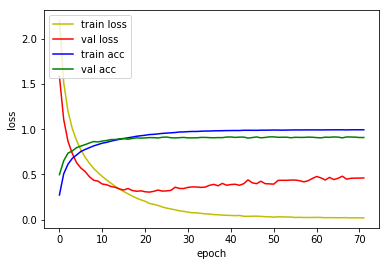

4815/4815 [==============================] - 1s 189us/sample - loss: 0.6756 - acc: 0.8750
Loss: 0.6756420808665354 Accuracy: 0.874974
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.9544 - acc: 0.3637
Epoch 00001: val_loss improved from inf to 1.31746, saving model to model/checkpoint/1D_CNN_4_conv_1_fcn_checkpoint/01-1.3175.hdf5
36805/36805 [==============================] - 17s 471us/sample - loss: 1.9543 - acc: 0.3638 - val_loss: 1.3175 - val_acc: 0.5931
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2186 - acc: 0.6098
Epoch 00002: val_loss improved from 1.31746 to 0.91785, saving model to model/checkpoint/1D_CNN_4_conv_1_fcn_checkpoint/02-0.9179.hdf5
36805/36805 [==============================] - 16s 432us/sample - loss: 1.2187 - acc: 0.6098 - val_loss: 0.9179 - val_acc: 0.7137
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9337 - acc: 0.7016
Epo

Epoch 54/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9887
Epoch 00054: val_loss did not improve from 0.27841
36805/36805 [==============================] - 16s 431us/sample - loss: 0.0357 - acc: 0.9887 - val_loss: 0.3889 - val_acc: 0.9252
Epoch 55/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9885
Epoch 00055: val_loss did not improve from 0.27841
36805/36805 [==============================] - 16s 430us/sample - loss: 0.0363 - acc: 0.9885 - val_loss: 0.3922 - val_acc: 0.9248
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9893
Epoch 00056: val_loss did not improve from 0.27841
36805/36805 [==============================] - 16s 431us/sample - loss: 0.0333 - acc: 0.9893 - val_loss: 0.3784 - val_acc: 0.9264
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9901
Epoch 00057: val_loss did not improve from 0.27841
36805/36805 [=====

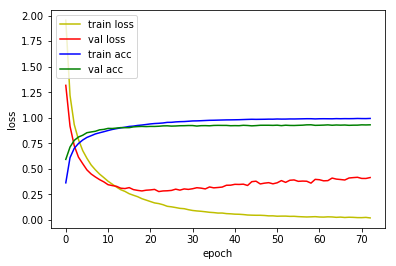

4815/4815 [==============================] - 1s 220us/sample - loss: 0.5232 - acc: 0.9045
Loss: 0.5232254924970221 Accuracy: 0.9044652
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.2361 - acc: 0.2620
Epoch 00001: val_loss improved from inf to 1.44974, saving model to model/checkpoint/1D_CNN_4_conv_2_fcn_checkpoint/01-1.4497.hdf5
36805/36805 [==============================] - 18s 483us/sample - loss: 2.2353 - acc: 0.2623 - val_loss: 1.4497 - val_acc: 0.5337
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4481 - acc: 0.5213
Epoch 00002: val_loss improved from 1.44974 to 1.04683, saving model to model/checkpoint/1D_CNN_4_conv_2_fcn_checkpoint/02-1.0468.hdf5
36805/36805 [==============================] - 16s 445us/sample - loss: 1.4482 - acc: 0.5213 - val_loss: 1.0468 - val_acc: 0.6506
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1228 - acc: 0.6331
Ep

36800/36805 [============================>.] - ETA: 0s - loss: 0.1390 - acc: 0.9538
Epoch 00025: val_loss improved from 0.23333 to 0.22871, saving model to model/checkpoint/1D_CNN_4_conv_2_fcn_checkpoint/25-0.2287.hdf5
36805/36805 [==============================] - 17s 451us/sample - loss: 0.1389 - acc: 0.9538 - val_loss: 0.2287 - val_acc: 0.9371
Epoch 26/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1292 - acc: 0.9567
Epoch 00026: val_loss did not improve from 0.22871
36805/36805 [==============================] - 16s 447us/sample - loss: 0.1292 - acc: 0.9567 - val_loss: 0.2346 - val_acc: 0.9341
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1234 - acc: 0.9584
Epoch 00027: val_loss did not improve from 0.22871
36805/36805 [==============================] - 17s 450us/sample - loss: 0.1234 - acc: 0.9584 - val_loss: 0.2593 - val_acc: 0.9273
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.962

Epoch 54/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9878
Epoch 00054: val_loss did not improve from 0.22673
36805/36805 [==============================] - 16s 448us/sample - loss: 0.0395 - acc: 0.9877 - val_loss: 0.2819 - val_acc: 0.9425
Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9875
Epoch 00055: val_loss did not improve from 0.22673
36805/36805 [==============================] - 16s 448us/sample - loss: 0.0394 - acc: 0.9875 - val_loss: 0.3176 - val_acc: 0.9401
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9891
Epoch 00056: val_loss did not improve from 0.22673
36805/36805 [==============================] - 16s 448us/sample - loss: 0.0349 - acc: 0.9891 - val_loss: 0.2858 - val_acc: 0.9397
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9874
Epoch 00057: val_loss did not improve from 0.22673
36805/36805 [=====

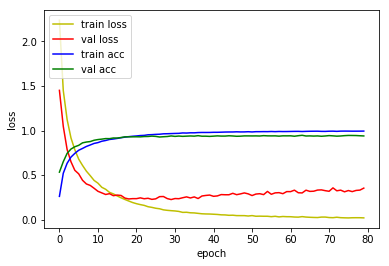

4815/4815 [==============================] - 1s 213us/sample - loss: 0.4991 - acc: 0.9153
Loss: 0.49909032661533553 Accuracy: 0.9152648
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.1019 - acc: 0.3060
Epoch 00001: val_loss improved from inf to 1.40551, saving model to model/checkpoint/1D_CNN_5_conv_1_fcn_checkpoint/01-1.4055.hdf5
36805/36805 [==============================] - 18s 485us/sample - loss: 2.1004 - acc: 0.3065 - val_loss: 1.4055 - val_acc: 0.5369
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.2422 - acc: 0.5962
Epoch 00002: val_loss improved from 1.40551 to 0.91132, saving model to model/checkpoint/1D_CNN_5_conv_1_fcn_checkpoint/02-0.9113.hdf5
36805/36805 [==============================] - 16s 432us/sample - loss: 1.2425 - acc: 0.5961 - val_loss: 0.9113 - val_acc: 0.7037
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9075 - acc: 0.7076
E

36800/36805 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9621
Epoch 00025: val_loss did not improve from 0.24706
36805/36805 [==============================] - 16s 434us/sample - loss: 0.1125 - acc: 0.9621 - val_loss: 0.2638 - val_acc: 0.9266
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9625
Epoch 00026: val_loss did not improve from 0.24706
36805/36805 [==============================] - 16s 437us/sample - loss: 0.1118 - acc: 0.9625 - val_loss: 0.2657 - val_acc: 0.9317
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1075 - acc: 0.9634
Epoch 00027: val_loss did not improve from 0.24706
36805/36805 [==============================] - 16s 436us/sample - loss: 0.1074 - acc: 0.9635 - val_loss: 0.2649 - val_acc: 0.9280
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9686
Epoch 00028: val_loss did not improve from 0.24706
36805/36805 [==================

Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9890
Epoch 00055: val_loss did not improve from 0.24706
36805/36805 [==============================] - 16s 436us/sample - loss: 0.0334 - acc: 0.9891 - val_loss: 0.3758 - val_acc: 0.9369
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0304 - acc: 0.9901
Epoch 00056: val_loss did not improve from 0.24706
36805/36805 [==============================] - 16s 434us/sample - loss: 0.0303 - acc: 0.9901 - val_loss: 0.3535 - val_acc: 0.9364
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9906
Epoch 00057: val_loss did not improve from 0.24706
36805/36805 [==============================] - 16s 433us/sample - loss: 0.0298 - acc: 0.9906 - val_loss: 0.3689 - val_acc: 0.9376
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9892
Epoch 00058: val_loss did not improve from 0.24706
36805/36805 [=====

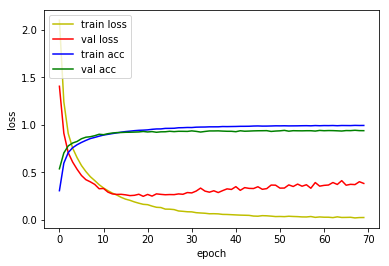

4815/4815 [==============================] - 1s 225us/sample - loss: 0.4773 - acc: 0.9124
Loss: 0.47725673490711645 Accuracy: 0.9123572
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.2821 - acc: 0.2424
Epoch 00001: val_loss improved from inf to 1.63259, saving model to model/checkpoint/1D_CNN_5_conv_2_fcn_checkpoint/01-1.6326.hdf5
36805/36805 [==============================] - 18s 502us/sample - loss: 2.2815 - acc: 0.2427 - val_loss: 1.6326 - val_acc: 0.4540
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.4736 - acc: 0.5075
Epoch 00002: val_loss improved from 1.63259 to 1.02034, saving model to model/checkpoint/1D_CNN_5_conv_2_fcn_checkpoint/02-1.0203.hdf5
36805/36805 [==============================] - 16s 439us/sample - loss: 1.4732 - acc: 0.5077 - val_loss: 1.0203 - val_acc: 0.6513
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0263 - acc: 0.6663
E

Epoch 54/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9892
Epoch 00054: val_loss did not improve from 0.21251
36805/36805 [==============================] - 16s 442us/sample - loss: 0.0328 - acc: 0.9892 - val_loss: 0.3194 - val_acc: 0.9469
Epoch 55/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9902
Epoch 00055: val_loss did not improve from 0.21251
36805/36805 [==============================] - 16s 443us/sample - loss: 0.0300 - acc: 0.9902 - val_loss: 0.3294 - val_acc: 0.9427
Epoch 56/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9901
Epoch 00056: val_loss did not improve from 0.21251
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0306 - acc: 0.9900 - val_loss: 0.3447 - val_acc: 0.9383
Epoch 57/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9896
Epoch 00057: val_loss did not improve from 0.21251
36805/36805 [=====

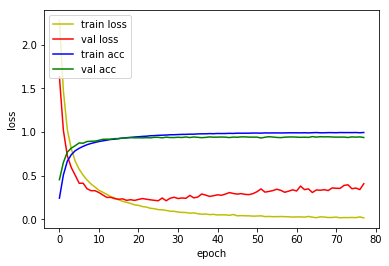

4815/4815 [==============================] - 1s 227us/sample - loss: 0.5374 - acc: 0.9167
Loss: 0.5374475752029603 Accuracy: 0.9167186


ValueError: Negative dimension size caused by subtracting 25 from 8 for 'conv1d_35/conv1d/Conv2D' (op: 'Conv2D') with input shapes: [?,1,8,128], [1,25,128,256].

In [14]:
for i in range(1, 5):
    for j in range(1, 3):
        model = build_batchnorm_cnn_no_do(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/1D_BN_CNN_NO_DO_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])

        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()

        png_path = 'visualization/learning_curve/'
        filename = '1D_BN_CNN_NO_DO_{}_conv_{}_fcn'.format(i, j)+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)

        del(model)
        
        model_path = 'model/checkpoint/1D_BN_CNN_NO_DO_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [12]:
for i in range(1, 6):
    for j in range(1, 3):
        print()
        print('{} Conv {} FCN Model'.format(i, j))
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/1D_CNN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        
        del(model)


1 Conv 1 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3994, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 31952)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              32719872  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                16400     
Total params: 32,736,480
Trainable params: 32,736,480
Non-trainable params: 0
____________________________________________

4815/4815 [==============================] - 1s 255us/sample - loss: 0.4532 - acc: 0.8702
Loss: 0.45320871350426045 Accuracy: 0.8701973

4 Conv 1 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 993, 16)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 969, 32)           12832     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 243, 32)        

4815/4815 [==============================] - 1s 310us/sample - loss: 0.3388 - acc: 0.9090
Loss: 0.33880567779669757 Accuracy: 0.90903425
